# Sandbox for building toy PyTorch models and testing them in Scramblers
I've been learning Pytorch and have put together some baby models on a toy dataset of 8-mers with 3-mer motifs to practice sticking tubes together. I also want to practice running scramblers to identify important sequences. 

I'm stuck but hopefully this notebook can demonstrate what I've tried and what might be wrong?


In [1]:
import torch
from torch import nn

from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
# create all possible n-mers for 8
seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [3]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
                  
def score_seqs_motif(seqs):
    '''
    Use simple system to assign scores to a given seq:
    Using above scoring dict, take the average score of the sequence. 
    If the sequence has a TAT, give it a 10pt bump.
    If it has a GCG, take away 10 pts
    (Simulating activating and repressing motifs)
    '''
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
    

In [5]:
mer8_motif = score_seqs_motif(seqs8)
mer8_motif.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


In [6]:
print(mer8_motif[mer8_motif['seq']=='TTTATTTT'])
print(mer8_motif[mer8_motif['seq']=='TGCGTTTT'])

            seq   score
64767  TTTATTTT  22.125
            seq  score
59135  TGCGTTTT    2.5


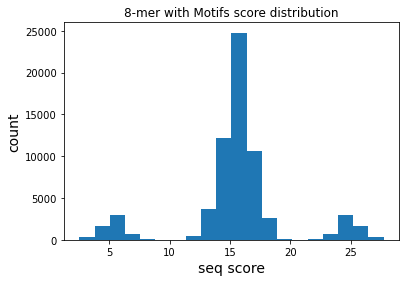

In [7]:
plt.hist(mer8_motif['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### Define some basic model archs for Linear and CNN

In [8]:
class DNA_Linear_Deep(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix?? I think the unsqueeze adds a necessary dimension for Conv2D?
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

In [9]:
def plot_train_test_hist(train_df, test_df,bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label="train")
    plt.hist(test_df['score'].values,bins=bins,label='test')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
    
def quick_test8(model, oracle):
    '''Sanity check some sequence predictions against the oracle (ground truth dict)'''
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        u.quick_seq_pred(model, seqs, oracle)
        print()

# Single task Regression with Motifs
### Split data into train and test

In [10]:
# build DataLoader objects in PyTorch, also return pandas dfs of the train and test seqs
mer8motif_train_dl, \
mer8motif_test_dl, \
mer8motif_train_df, \
mer8motif_test_df = u.build_dataloaders_single(mer8_motif, batch_size=13)

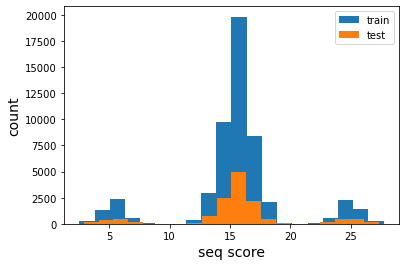

In [11]:
plot_train_test_hist(mer8motif_train_df, mer8motif_test_df,bins=20)

In [12]:
mer8motif_train_df['oh'].values[0].shape

(8, 4)

In [13]:
# inspect some stuff about a batch
for xb, yb in mer8motif_train_dl:
    break

# print some stuff that happens in the forward pass of the PyTorch model
print("xb shape:",xb.shape)
print("xb shape after forward pass:",xb.permute(0,2,1).unsqueeze(1).shape)
print(xb.permute(0,2,1).unsqueeze(1))

xb shape: torch.Size([13, 8, 4])
xb shape after forward pass: torch.Size([13, 1, 4, 8])
tensor([[[[0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 1., 0., 0., 0., 1., 0., 0.],
          [0., 0., 1., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 1., 0.]]],


        [[[0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 1., 0., 0., 1., 0., 0., 1.],
          [0., 0., 1., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 1., 1., 0.]]],


        [[[1., 0., 0., 0., 0., 1., 0., 1.],
          [0., 1., 0., 0., 1., 0., 1., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0.]]],


        [[[0., 1., 1., 1., 0., 0., 1., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0.],
          [1., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1.]]],


        [[[0., 0., 0., 0., 1., 1., 0., 0.],
          [1., 1., 0., 1., 0., 0., 1., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1.]]],


        [[[0

##  Linear Model

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/torch/autograd/__init__.py:149: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/cuda/CUDAFunctions.cpp:115.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


0 7.298014665399341
1 4.830536375531053
2 3.758235338633112
3 3.0617318206901842
4 2.263229434837428
5 2.0471202440612157
6 1.3583737193997
7 1.0989971940062069
8 0.9329651279086778
9 0.9082946633174902
10 0.9163997002601906
11 0.8181010219974737
12 0.7677742120124079
13 1.7697973465720327
14 0.5902624033044184
15 0.6177609452291718
16 0.6140612181839367
17 0.672745149576372
18 1.1800101330929553
19 0.5810934314427532


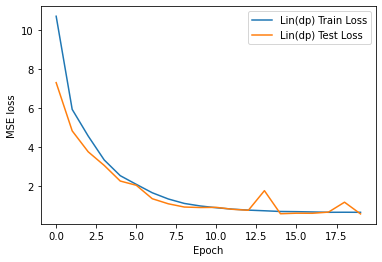

In [14]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_d = DNA_Linear_Deep(seq_len,hidden_layer_size)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_d
)

# to plot loss
mer8motif_lin_d_data_label = list(zip([mer8motif_train_losses_lin_d,
                                       mer8motif_test_losses_lin_d], 
                                      ['Lin(dp) Train Loss',
                                       'Lin(dp) Test Loss']))
u.quick_loss_plot(mer8motif_lin_d_data_label)

In [15]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_d,oracle_8mer_motif)

AAAAAAAA: pred:20.407 actual:20.000 (-0.407)
CCCCCCCC: pred:17.154 actual:17.000 (-0.154)
GGGGGGGG: pred:13.873 actual:14.000 (0.127)
TTTTTTTT: pred:12.535 actual:11.000 (-1.535)

AACCAACA: pred:19.680 actual:18.875 (-0.805)
CCGGCGCG: pred:0.000 actual:5.500 (5.500)
GGGTAAGG: pred:15.549 actual:15.125 (-0.424)
TTTCGTTT: pred:11.881 actual:12.125 (0.244)
TGTAATAC: pred:15.950 actual:15.500 (-0.450)

TATAAAAA: pred:26.361 actual:27.750 (1.389)
CCTATCCC: pred:25.059 actual:25.875 (0.816)
GTATGGGG: pred:23.580 actual:24.000 (0.420)
TTTATTTT: pred:21.047 actual:22.125 (1.078)

AAGCGAAA: pred:7.732 actual:8.125 (0.393)
CGCGCCCC: pred:6.520 actual:6.250 (-0.270)
GGGCGGGG: pred:4.397 actual:4.375 (-0.022)
TTGCGTTT: pred:2.864 actual:2.500 (-0.364)

ATATGCGA: pred:16.587 actual:15.875 (-0.712)
TGCGTATT: pred:14.260 actual:13.625 (-0.635)



### CNN Model

0 0.4765327754366528
1 0.1570231312616459
2 0.046843871257918994
3 0.029868828262592365
4 0.013718355558184892
5 0.00854265474538348
6 0.010521948389252642
7 0.006266354176536156
8 0.005913617471550604
9 0.004782517314920865
10 0.004891932779237769
11 0.0044633977875948114
12 0.003749687698227659
13 0.0035985081395560844
14 0.0032765557422854866
15 0.003626778771706426
16 0.0029563801821182807
17 0.0032281302727915125
18 0.0033545040094249533
19 0.0027883732697468653


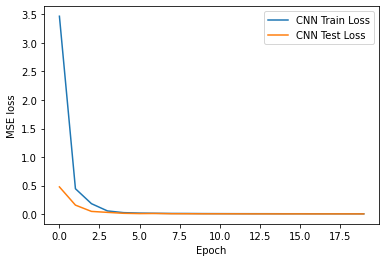

In [16]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnn = DNA_CNN(seq_len)

mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnn, 
)

# to plot loss
mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer8motif_cnn_data_label)

In [17]:
quick_test8(mer8motif_model_cnn, oracle_8mer_motif)

AAAAAAAA: pred:20.049 actual:20.000 (-0.049)
CCCCCCCC: pred:17.019 actual:17.000 (-0.019)
GGGGGGGG: pred:14.023 actual:14.000 (-0.023)
TTTTTTTT: pred:11.054 actual:11.000 (-0.054)

AACCAACA: pred:18.857 actual:18.875 (0.018)
CCGGCGCG: pred:5.632 actual:5.500 (-0.132)
GGGTAAGG: pred:15.108 actual:15.125 (0.017)
TTTCGTTT: pred:12.184 actual:12.125 (-0.059)
TGTAATAC: pred:15.516 actual:15.500 (-0.016)

TATAAAAA: pred:27.795 actual:27.750 (-0.045)
CCTATCCC: pred:25.909 actual:25.875 (-0.034)
GTATGGGG: pred:24.007 actual:24.000 (-0.007)
TTTATTTT: pred:22.109 actual:22.125 (0.016)

AAGCGAAA: pred:8.151 actual:8.125 (-0.026)
CGCGCCCC: pred:6.224 actual:6.250 (0.026)
GGGCGGGG: pred:4.425 actual:4.375 (-0.050)
TTGCGTTT: pred:2.694 actual:2.500 (-0.194)

ATATGCGA: pred:15.734 actual:15.875 (0.141)
TGCGTATT: pred:13.655 actual:13.625 (-0.030)



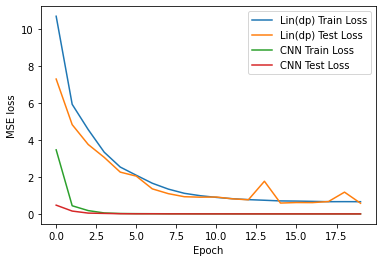

In [18]:
u.quick_loss_plot(
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label
)

In [19]:
def parity_pred(models, seqs, oracle,task,alt=True):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model in models:
        print(f"Running {model_name}")
        data = []
        for dna in seqs:
            s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0)
            actual = oracle[dna]
            pred = model(s.float())
            data.append([dna,actual,pred.item()])
        df = pd.DataFrame(data, columns=['seq','truth','pred'])
        pearson = df['truth'].corr(df['pred'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            u.alt_parity_plot(model_name, df, pearson,task)
        u.parity_plot(model_name, df, pearson)

    return dfs

Running LinearDeep_8mer


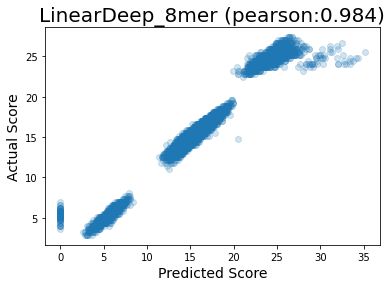

Running CNN_8mer


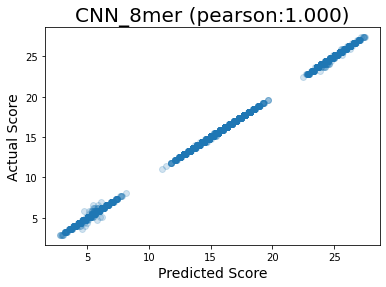

In [20]:
models = [
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
]

seqs = mer8motif_test_df['seq'].values
task = "TATGCGmotif"

dfs = parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)

# Checkpoint 1
The models are trained in PyTorch and are working as expected: the linear model does pretty good (it's a simple task) but the CNN model is doing much better. 

I'd like to practice using Scramblers, and I expect that Scramblers should see that the models are indeed relying on the TAT and GCG motifs to predict the scoring pattern.

However, Scramblers are in Keras, not PyTorch. 

So I'm trying to use ONNX to convert the PyTorch models to Keras. Unfortunately, ONNX uses tf.Keras while scramblers just use Keras. So this will actually be 2 steps:
1. Convert PyTorch to tf.Keras (via ONNX)
2. Convert tf.Keras to Keras


## try to export to keras

In [21]:
mer8motif_model_lin_d

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=24, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): ReLU(inplace=True)
  )
)

In [22]:
mer8motif_model_cnn

DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 31, kernel_size=(4, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=186, out_features=10, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

### Try onnx export

In [23]:
import keras
import onnx
import onnx2keras
from onnx2keras import onnx_to_keras

Using TensorFlow backend.
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [24]:
seqs = ["AAAAAAAA","TTTTTTTT","CCCCCCCC","GGGGGGGG","GGGTATGG","AAGCGAAA"]

In [25]:
def export2keras(pt_model, model_name_str,example_seqs):
    
    # make dummy input from example seqs
    ohe_seqs = [u.one_hot_encode(x) for x in example_seqs]
    ohe_seqs = [torch.from_numpy(x).unsqueeze(0).float() for x in ohe_seqs]
    dummy_input = ohe_seqs[0]
    
    # export intermediate ONNX model
    onnx_model_str = f"{model_name_str}.onnx"
    torch.onnx.export(
        pt_model, 
        dummy_input, 
        onnx_model_str, 
        input_names=['test_input'], # should this change? Does it matter?
        output_names=['test_output']
    )
    print("Done saving to onnx.")
    print("Loading to Keras...")
    
    # convert ONNX to keras
    onnx_model = onnx.load(onnx_model_str)
    k_model = onnx_to_keras(onnx_model, ['test_input'])
    
    print("\nConfirming Torch and Keras match")
    # confirm Pytorch and Keras agree
    for i in range(len(example_seqs)):
        seq = example_seqs[i]
        ohe_seq = ohe_seqs[i]
        seq_k = np.array(ohe_seq)

        res = pt_model(ohe_seq)
        res2 = k_model.predict(seq_k)
        
        print(f"{seq}: \n\tPyTorch:{res.item()} \n\tKeras  :{res2[0][0]}")
        
    # save the Keras model
    k_model_str = f"{model_name_str}.h5"
    
    k_model.save(k_model_str)
    print(f"Keras Model saved at {k_model_str}")
    return k_model


In [114]:
tf.__version__

'1.13.1'

In [26]:
k_lin_d_model = export2keras(mer8motif_model_lin_d, "mer8motif_model_lin_d",seqs)

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> test_input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> test_output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight lin.0.weight with shape (24, 32).
DEBUG:onnx2keras:Found weight lin.0.bias with shape (24,).
DEBUG:onnx2keras:Found weight lin.2.weight with shape (1, 24).
DEBUG:onnx2keras:Found weight lin.2.bias with shape (1,).
DEBUG:onnx2keras:Found weight 17 with shape (1,).
DEBUG:onnx2keras:Found input test_input with shape [8, 4]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Shape
DEBUG:onnx2keras:node_name: 5
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name test_input).
DEBUG:onnx2k

Done saving to onnx.
Loading to Keras...
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.
DEBUG:onnx2keras:Output TF Layer -> Tensor("13/BiasAdd:0", shape=(?, 24), dtype=float32)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: 14
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 13).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:Output TF Layer -> Tensor("14/Relu:0", shape=(?, 24), dtype=float32)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Gemm
DEBUG:onnx2keras:node_name: 15
DEBUG:onnx2keras:node_params: {'alpha': 1.0, 'beta': 1.0, 'transB': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (na


Confirming Torch and Keras match
AAAAAAAA: 
	PyTorch:20.406902313232422 
	Keras  :20.406902313232422
TTTTTTTT: 
	PyTorch:12.535486221313477 
	Keras  :12.535486221313477
CCCCCCCC: 
	PyTorch:17.153942108154297 
	Keras  :17.15393829345703
GGGGGGGG: 
	PyTorch:13.873432159423828 
	Keras  :13.873430252075195
GGGTATGG: 
	PyTorch:22.243972778320312 
	Keras  :22.243968963623047
AAGCGAAA: 
	PyTorch:7.731834411621094 
	Keras  :7.731834411621094
Keras Model saved at mer8motif_model_lin_d.h5


In [27]:
k_cnn_model = export2keras(mer8motif_model_cnn, "mer8motif_model_cnn",seqs)

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> test_input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> test_output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight conv_net.0.weight with shape (31, 1, 4, 3).
DEBUG:onnx2keras:Found weight conv_net.0.bias with shape (31,).
DEBUG:onnx2keras:Found weight conv_net.3.weight with shape (10, 186).
DEBUG:onnx2keras:Found weight conv_net.3.bias with shape (10,).
DEBUG:onnx2keras:Found weight conv_net.5.weight with shape (1, 10).
DEBUG:onnx2keras:Found weight conv_net.5.bias with shape (1,).
DEBUG:onnx2keras:Found input test_input with shape [8, 4]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Transpose
DEBUG:onnx2keras:node_name: 7
DEBUG:onnx2keras:node_params: {'perm': [0, 2, 1], 'change_ordering': False, 'name_policy': None}
DEB

Done saving to onnx.
Loading to Keras...


DEBUG:onnx2keras:Output TF Layer -> Tensor("12_2/BiasAdd:0", shape=(?, 10), dtype=float32)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: 13
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 12).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:Output TF Layer -> Tensor("13_1/Relu:0", shape=(?, 10), dtype=float32)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Gemm
DEBUG:onnx2keras:node_name: test_output
DEBUG:onnx2keras:node_params: {'alpha': 1.0, 'beta': 1.0, 'transB': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 13).
DEBUG:onnx2keras:Check input 1 (name conv_net.5.wei


Confirming Torch and Keras match
AAAAAAAA: 
	PyTorch:20.049259185791016 
	Keras  :20.049257278442383
TTTTTTTT: 
	PyTorch:11.053607940673828 
	Keras  :11.053607940673828
CCCCCCCC: 
	PyTorch:17.018943786621094 
	Keras  :17.018943786621094
GGGGGGGG: 
	PyTorch:14.023262977600098 
	Keras  :14.023262977600098
GGGTATGG: 
	PyTorch:24.014760971069336 
	Keras  :24.014759063720703
AAGCGAAA: 
	PyTorch:8.15086841583252 
	Keras  :8.15086841583252
Keras Model saved at mer8motif_model_cnn.h5


The models seems to be predicting the same out to ~5 decimals between PyTorch and Keras!

# Test Keras model in Scramblers
Using notebook template from optimus prime example

In [28]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores

#from optimus5_utils import load_optimus5_data, load_optimus5_predictor, animate_optimus5_examples

import utils as u
SEQ_LEN=8

In [29]:
# use same train/test sets as above
encoder = OneHotEncoder(seq_length=SEQ_LEN, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

x_train = np.array([encoder(seq[0]).reshape(1, SEQ_LEN, 4) for seq in mer8motif_train_df[['seq']].values])
x_test = np.array([encoder(seq[0]).reshape(1, SEQ_LEN, 4) for seq in mer8motif_test_df[['seq']].values])

y_train = mer8motif_train_df[['score']].values
y_test = mer8motif_test_df[['score']].values


# Apparently keras can't deal with training sets that are not 
# an exact multiple of the batch size... sooo... trim some?
train_trim = 12
test_trim = 20

x_train = x_train[:-train_trim]
x_test = x_test[:-test_trim]
y_train = y_train[:-train_trim]
y_test = y_test[:-test_trim]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(52416, 1, 8, 4)
(52416, 1)
(13088, 1, 8, 4)
(13088, 1)


In [30]:
#Define sequence template and background

#sequence_template = '$' * 50
sequence_template = '$' * SEQ_LEN

pseudo_count = 1.0

onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]

# This is the background? So it's a mean by position... I'll probs change this...
x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)

print(sequence_template)
print(onehot_template)
print(sequence_mask)
print(x_mean)
print(x_mean.shape)

$$$$$$$$
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
[1 1 1 1 1 1 1 1]
[[0.24929416 0.25099199 0.24954216 0.25017169]
 [0.24925601 0.25061045 0.25116368 0.24896986]
 [0.24906524 0.24925601 0.24961847 0.25206028]
 [0.24996185 0.25011446 0.24923693 0.25068676]
 [0.24887448 0.2503243  0.25053415 0.25026707]
 [0.25141167 0.24965662 0.24866463 0.25026707]
 [0.25087753 0.24807325 0.25198398 0.24906524]
 [0.24977108 0.25076307 0.24998092 0.24948493]]
(8, 4)


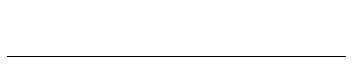

Mean KL Div against background (bits) = 1.9999891911093224


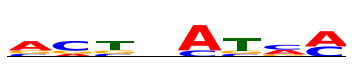

In [32]:
#Visualize background sequence distribution
plot_dna_logo(
    np.copy(x_mean), 
    sequence_template=sequence_template, 
    figsize=(5, 1), logo_height=1.0, 
    plot_start=0, plot_end=SEQ_LEN)


#Calculate mean training set kl-divergence against background
# resets one hot to almost 0 and almost 1... why?
#x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)
x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

# (train size, 50)
kl_divs = np.sum(x_train_clipped * \
                 np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), 
                                                  (x_train_clipped.shape[0], 1, 1))), axis=-1)\
            / np.log(2.0)

# train size
x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
# 1
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


# Plot test array just so I can see some letters show up
test = np.array([[.6, .2, .2, .0],
                 [.2, .6, .2, .0],
                 [.0, .2, .2, .6],
                 [.3, .2, .2, .3],
                 [.8, .2, .0, .0],
                 [.0, .2, .2, .8],
                 [.4, .4, .2, .0],
                 [.6, .4, .0, .0],
                ])
plot_dna_logo(
    np.copy(test), 
    sequence_template=sequence_template, 
    figsize=(5, 1), logo_height=1.0, 
    plot_start=0, plot_end=SEQ_LEN)

## Scramblin' Time
I changed some of the settings to try to make the smallest scrambler network as possible because the sequences are so small!

In [42]:
#Plot training statistics
def plot_training_stats(train_history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

    n_epochs_actual = len(train_history['nll_loss'])

    ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['nll_loss'], linewidth=3, color='green',label='nll_loss')
    ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['val_nll_loss'], linewidth=3, color='orange',label='vall_nll_loss')

    plt.sca(ax1)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("NLL", fontsize=14)
    plt.xlim(1, n_epochs_actual)
    plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()

    ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['entropy_loss'], linewidth=3, color='green',label='entropy_loss')
    ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['val_entropy_loss'], linewidth=3, color='orange',label='val_entropy_loss')

    plt.sca(ax2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Entropy Loss", fontsize=14)
    plt.xlim(1, n_epochs_actual)
    plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()

    plt.tight_layout()

    plt.show()

def build_scrambler():
    #Scrambler network configuration
    network_config = {
        'n_groups' : 1,
        'n_resblocks_per_group' : 1, # resblock has 2 conv layers
        'n_channels' : 32, # num filters
        'window_size' : 3, # kernel size
        'dilation_rates' : [1],
        'drop_rate' : 0.0,
        'norm_mode' : 'instance', # some sort of normalization
        'mask_smoothing' : False, # "smooth" not referenced in paper or github instructions
        'mask_smoothing_window_size' : 5,
        'mask_smoothing_std' : 1.,
        'mask_drop_scales' : [1, 5],
        'mask_min_drop_rate' : 0.0,
        'mask_max_drop_rate' : 0.5,
        'label_input' : False
    }

    #Initialize scrambler
    scrambler = Scrambler(
        scrambler_mode='inclusion',
        input_size_x=1,
        input_size_y=SEQ_LEN,
        n_out_channels=4,
        input_templates=[onehot_template],
        input_backgrounds=[x_mean],
        batch_size=32,
        n_samples=32,
        sample_mode='gumbel',
        zeropad_input=False,
        mask_dropout=False,
        network_config=network_config
    )
    
    return scrambler

def train_scrambler_on_model(model, n_epochs=10):
    # init scrambler object
    scr = build_scrambler()
    
    # train scrambler on model
    train_history = scr.train(
        model,
        x_train,
        y_train,
        x_test,
        y_test,
        n_epochs,
        monitor_test_indices=np.arange(32).tolist(),
        monitor_batch_freq_dict={0 : 1, 100 : 5, 469 : 10},
        nll_mode='reconstruction',
        predictor_task='regression',
        entropy_mode='target',
        entropy_bits=0.125,
        entropy_weight=10.
    )
    
    # plot 
    plot_training_stats(train_history)
    
    return scr, train_history

def save_scrambler(scrambler, train_history, model_name,save_dir="saved_models"):
    #Save scrambler checkpoint

    #model_name = 'optimus5_inclusion_scrambler_bits_0125_epochs_10'
    #model_name = 'mer8motif_model_lin_d_inclusion_scrambler_bits_0125_epochs_10'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name + '.h5')

    scrambler.save_model(model_path)

    pickle.dump({'train_history' : train_history}, open(save_dir + '/' + model_name + '_train_history.pickle', 'wb'))



In [43]:
lin_d_scr, lin_d_scr_train_hist = train_scrambler_on_model(k_lin_d_model)
model_name = 'mer8motif_model_lin_d_inclusion_scrambler_bits_0125_epochs_10'
save_scrambler(lin_d_scr, lin_d_scr_train_hist, model_name)

SCRAMBLER INITIATED!!
IN SCRAMBLER TRAIN!


ValueError: ('Could not interpret optimizer identifier:', <keras.optimizers.SGD object at 0x7fc9089cd190>)

# Error! 
I think this has to do with ONNX using tf.keras and Scramblers using regular keras.

In [44]:
k_lin_d_model

In [45]:
k_cnn_model

# try to Save as h5 and reload in keras (remove tensorflow)

Optimus model loaded in Scrambler example is `keras.engine.training.Model`

In [46]:
# conf = k_lin_d_model.get_config()
# k_lin_no_tf = keras.models.Model.from_config(conf)
# k_lin_no_tf # try saving then reloading
# ^^ Ran in scrambler but must not have had weights? Scrambler didn't learn anything...

In [56]:
k_lin_d_model.save("k_lin_d.h5")
k_lin_no_tf = keras.models.load_model("k_lin_d.h5")
k_lin_no_tf

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


SCRAMBLER INITIATED!!
IN SCRAMBLER TRAIN!
predictor is compiled??
Scrambler has created inputs...
Starting to build lambda stuff?
About to predict stuff...
Inflating?
Calculating NLL / error?
Calculated NLL?: Tensor("nll_4/mul:0", shape=(32,), dtype=float32)
Made Loss Model
Compiled loss model: <keras.engine.training.Model object at 0x7fc8e378d890>
label train and test? [] []
APPENDING to callbacks
Fitting loss model...
	group train 1 (52416, 1)
	x train 1 (52416, 1, 8, 4)
	drop train 0 []
	label train 0 []

n epochs: 10
batch size: 32
callbacks: [<scrambler.models.scrambler_models.ScramblerMonitor object at 0x7fc8e36a7dd0>]
Train on 52416 samples, validate on 13088 samples
Epoch 1/10
52416/52416 [==============================] - 57s 1ms/step - loss: 20.6728 - nll_loss: 6.5726 - entropy_loss: 14.1002 - val_loss: 15.8754 - val_nll_loss: 4.4676 - val_entropy_loss: 11.4079
Epoch 2/10
52416/52416 [==============================] - 39s 740us/step - loss: 14.9313 - nll_loss: 4.1243 - entrop

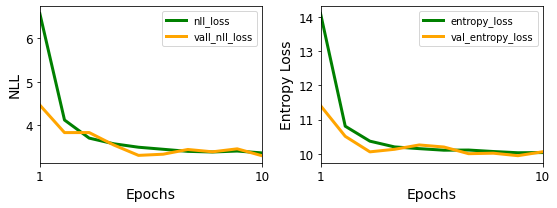

Saved scrambler model at saved_models/mer8motif_model_lin_d_inclusion_scrambler_bits_0125_epochs_10.h5 


In [57]:
lin_d_scr, lin_d_scr_train_hist = train_scrambler_on_model(k_lin_no_tf)
model_name = 'mer8motif_model_lin_d_inclusion_scrambler_bits_0125_epochs_10'
save_scrambler(lin_d_scr, lin_d_scr_train_hist, model_name)

## Eval scrambler results?
So the scrambler ran on the linear model - now check the scrambler results by visualizing some sequences and their importances

In [59]:
# get seqs from test df that are ineresting to spot check
test_df = mer8motif_test_df.reset_index()

tat = list(test_df[test_df['seq'].str.contains("TAT")].index)
gcg = list(test_df[test_df['seq'].str.contains("GCG")].index)

print("Num TAT:",len(tat))
print("Num TAT:",len(gcg))

# Show some examples
list_idx = 2
g = gcg[list_idx]
print(f'GCG example idx {g}: {test_df.loc[g]["seq"]}')

list_idx = 1145
t = tat[list_idx]
print(f'TAT example idx {t}: {test_df.loc[t]["seq"]}')

# some idxs I checked and think are interesting?
ixs = [4,133,97,99,13074,13075,578,579,438,439]

Num TAT: 1146
Num TAT: 1124
GCG example idx 133: AAAGCGAA
TAT example idx 13074: TTTTATAG


13088/13088 [==============================] - 4s 291us/step
Test sequence 4:
 - Prediction (original) = 19.3
 - Predictions (scrambled) = [18.0, 18.0, 16.3, 17.3, 18.7, 17.6, 17.8, 19.2, 16.8, 18.7, 18.1, 16.8, 16.7, 17.6, 17.4, 17.7, 17.2, 18.5, 17.9, 17.9, 18.1, 18.9, 16.6, 16.7, 18.4, 16.4, 17.7, 18.3, 18.6, 17.6, 16.1, 16.5]


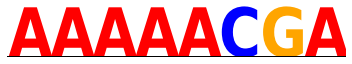

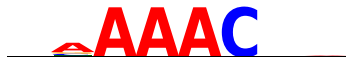

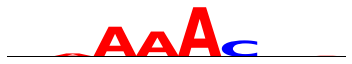

Test sequence 133:
 - Prediction (original) = 7.91
 - Predictions (scrambled) = [6.04, 5.34, 6.14, 5.53, 5.59, 6.48, 5.52, 5.81, 6.06, 4.31, 5.75, 6.24, 6.24, 6.49, 5.71, 6.01, -0.0, 5.63, 3.27, 5.59, 5.52, 5.85, 4.31, 5.74, 6.0, 5.71, 5.75, 6.5, 6.49, 6.41, 5.61, 6.16]


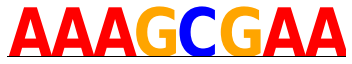

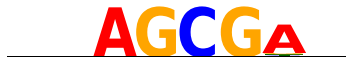

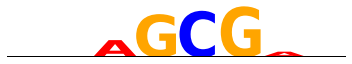

Test sequence 97:
 - Prediction (original) = 27.2
 - Predictions (scrambled) = [25.3, 26.3, 26.4, 26.9, 25.9, 26.2, 26.2, 24.8, 25.2, 24.1, 26.1, 24.5, 26.0, 25.1, 25.3, 25.0, 26.0, 25.2, 26.6, 26.2, 25.5, 25.4, 24.5, 26.1, 25.4, 25.1, 25.5, 26.1, 25.2, 25.7, 25.3, 25.0]


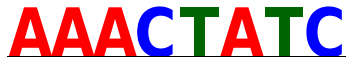

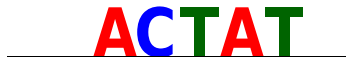

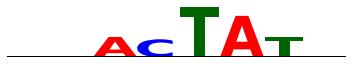

Test sequence 99:
 - Prediction (original) = 18.7
 - Predictions (scrambled) = [15.2, 16.7, 16.4, 16.2, 16.6, 16.7, 17.1, 18.0, 15.8, 16.1, 15.0, 17.8, 16.0, 16.9, 16.7, 16.7, 16.4, 17.7, 16.3, 17.3, 17.0, 15.8, 16.9, 17.2, 17.0, 16.4, 17.2, 17.0, 15.9, 17.3, 16.4, 16.2]


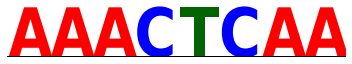

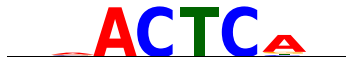

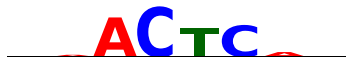

Test sequence 13074:
 - Prediction (original) = 22.2
 - Predictions (scrambled) = [23.0, 21.1, 23.2, 22.0, 22.2, 20.5, 24.3, 23.9, 26.7, 22.2, 20.3, 22.9, 24.4, 30.6, 22.3, 22.2, 23.6, 23.5, 23.5, 22.9, 24.7, 24.2, 21.8, 21.7, 21.8, 20.5, 23.1, 21.6, 23.3, 20.2, 23.3, 21.9]


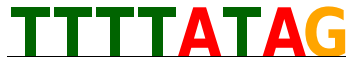

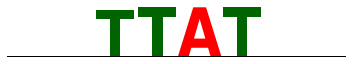

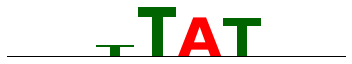

Test sequence 13075:
 - Prediction (original) = 13.8
 - Predictions (scrambled) = [15.5, 15.5, 14.1, 16.1, 15.6, 13.8, 14.3, 14.9, 14.8, 14.1, 15.7, 13.9, 14.8, 20.7, 15.7, 15.1, 15.6, 13.8, 14.2, 13.8, 15.0, 14.7, 13.5, 14.7, 15.3, 14.2, 15.5, 14.4, 14.1, 15.5, 16.0, 14.6]


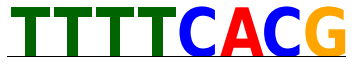

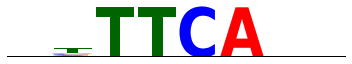

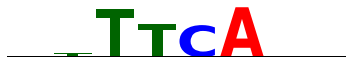

Test sequence 578:
 - Prediction (original) = 25.3
 - Predictions (scrambled) = [23.6, 24.3, 24.5, 24.1, 17.9, 24.7, 24.6, 24.6, 22.9, 24.4, 24.5, 24.7, 24.4, 24.3, 24.3, 24.9, 23.1, 24.7, 24.2, 24.2, 24.7, 25.0, 23.9, 24.5, 24.5, 23.3, 23.8, 23.0, 25.0, 24.2, 23.3, 24.4]


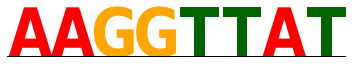

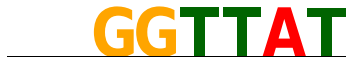

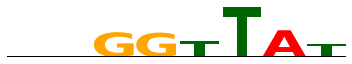

Test sequence 579:
 - Prediction (original) = 14.9
 - Predictions (scrambled) = [13.7, 13.4, 11.8, 13.6, 13.5, 13.5, 11.6, 12.7, 14.5, 13.0, 13.1, 14.2, 12.5, 12.6, 12.1, 13.9, 13.4, 13.3, 12.0, 13.4, 11.8, 14.9, 16.4, 13.8, 13.9, 14.1, 13.3, 12.9, 17.0, 13.0, 12.3, 13.1]


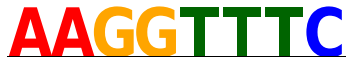

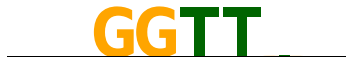

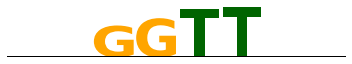

Test sequence 438:
 - Prediction (original) = 7.07
 - Predictions (scrambled) = [5.61, 6.75, 2.72, 6.02, 6.44, 6.09, 5.38, 6.4, 5.59, 6.18, 4.98, 4.07, -0.0, 5.68, 6.45, 6.73, -0.0, 5.52, 6.28, 6.48, 5.31, 5.31, 6.5, 5.73, 4.03, 6.01, 5.8, 5.05, 5.42, 4.7, 6.31, 5.68]


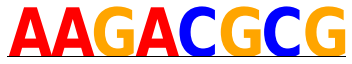

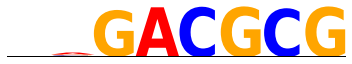

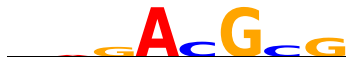

Test sequence 439:
 - Prediction (original) = 16.9
 - Predictions (scrambled) = [11.4, 15.6, 16.2, 16.1, 15.7, 15.5, 16.5, 15.8, 14.2, 15.8, 16.7, 16.6, 16.2, 15.4, 16.2, 16.4, 15.5, 15.8, 15.4, 15.5, 15.9, 13.9, 15.9, 15.3, 16.5, 14.5, 16.1, 14.9, 15.5, 16.0, 15.4, 15.9]


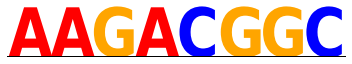

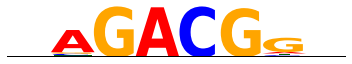

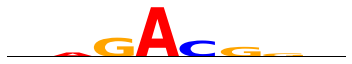

In [61]:
viz_scrambler_results(k_lin_no_tf, lin_d_scr)

# Checkpoint 2
### Scramblers working for linear model!
Running the scrambler on the linear model, it seems to highlight GCGs and TATs when present, though it is not perfect. Some other surrounding letters get lumped in too.

# Next: run scramblers on the CNN model

In [62]:
k_cnn_model.save("k_cnn.h5")
k_cnn_no_tf = keras.models.load_model("k_cnn.h5")
k_cnn_no_tf

TypeError: ('Keyword argument not understood:', 'module')

# Error! Can't reload tf.keras into Keras for CNNs
I've tried tracing the reason for this and best I can tell, it's that ONNX creates a lamba layer for the CNN model when translating the `unsqueeze()` command from PyTorch to keras. However this lambda layer is defined, it works in tf.keras but not in regular keras.

In [63]:
k_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 8, 4)              0         
_________________________________________________________________
7 (Permute)                  (None, 4, 8)              0         
_________________________________________________________________
8 (Lambda)                   (None, 1, 4, 8)           0         
_________________________________________________________________
9 (Conv2D)                   (None, 31, 1, 6)          403       
_________________________________________________________________
10 (Activation)              (None, 31, 1, 6)          0         
_________________________________________________________________
11 (Reshape)                 (None, None)              0         
_________________________________________________________________
12_reshape (Reshape)         (None, 186)               0         
__________

In [74]:
# I think this is the layer causing issues
k_cnn_model.get_config()['layers'][2]

{'name': '8',
 'class_name': 'Lambda',
 'config': {'name': '8',
  'trainable': True,
  'dtype': 'float32',
  'function': ('4wIAAAAAAAAAAwAAAAQAAABTAAAAcxoAAABkAWQCbABtAX0CAQB8AmoCoAN8AHwBoQJTACkDTukA\nAAAAKQHaBWtlcmFzKQTaCnRlbnNvcmZsb3dyAgAAANoHYmFja2VuZNoLZXhwYW5kX2RpbXMpA9oB\neNoEYXhpc3ICAAAAqQByCAAAAPpgL2hvbWUvZXdpbHNvbjYvYW5hY29uZGEzL2VudnMvc2NyYW1i\nbGVyL2xpYi9weXRob24zLjcvc2l0ZS1wYWNrYWdlcy9vbm54MmtlcmFzL3Jlc2hhcGVfbGF5ZXJz\nLnB52gx0YXJnZXRfbGF5ZXLhAAAAcwQAAAAAAQwB\n',
   (1,),
   None),
  'module': 'onnx2keras.reshape_layers',
  'function_type': 'lambda',
  'output_shape': None,
  'output_shape_type': 'raw',
  'output_shape_module': None,
  'arguments': {}},
 'inbound_nodes': [[['7', 0, 0, {}]]]}

### ^^ keras doesn't know what a "module" is? Must be a tf.keras thing...

# Other tried to convert tf.keras to Keras Model
ONNX uses tf.keras, but scramblers uses Keras. We need to convert it before using in scramblers, but for CNNs, I can't seem to just use `keras.models.load_model()`... there's formatting incompatibility

Things that did not work:
* Just using tf.keras.Model in scramblers - broke in scrambler as above with the SGD error
* Just recasting as a keras model - broke in scramblers
  * `cnn_test = keras.models.Model(k_lin_d_model)`

* saving and reloading from json or config file
  * keras still doesn't know about 'module' 
  
Current thing that is partially working to at least load into scramblers:
1. make tf.keras model as json object
2. Delete part of json that keras doesn't recognize
  * `del json_['config']['layers'][2]['config']['module']`
  * `del json_['config']['layers'][2]['config']['output_shape_module']`
    * I believe these have to do with the Unsqueeze function that happens in the pytorch cnn... Not sure how to get this to work in keras
3. convert to json string
4. load into keras.Model
5. save weights from tf.keras model
6. load weights into keras.Model

This seems to preserve the predictions still and can go into scramblers, but then it breaks at scrambler prediction time with dimension mismatches. And thus I'm stuck again.



### Demo of json manual deletions

In [75]:
import json

In [76]:
kjson = k_cnn_model.to_json()
json_obj = json.loads(kjson)

In [77]:
json_obj['config']['layers'][2]['config']

{'name': '8',
 'trainable': True,
 'dtype': 'float32',
 'function': ['4wIAAAAAAAAAAwAAAAQAAABTAAAAcxoAAABkAWQCbABtAX0CAQB8AmoCoAN8AHwBoQJTACkDTukA\nAAAAKQHaBWtlcmFzKQTaCnRlbnNvcmZsb3dyAgAAANoHYmFja2VuZNoLZXhwYW5kX2RpbXMpA9oB\neNoEYXhpc3ICAAAAqQByCAAAAPpgL2hvbWUvZXdpbHNvbjYvYW5hY29uZGEzL2VudnMvc2NyYW1i\nbGVyL2xpYi9weXRob24zLjcvc2l0ZS1wYWNrYWdlcy9vbm54MmtlcmFzL3Jlc2hhcGVfbGF5ZXJz\nLnB52gx0YXJnZXRfbGF5ZXLhAAAAcwQAAAAAAQwB\n',
  [1],
  None],
 'module': 'onnx2keras.reshape_layers',
 'function_type': 'lambda',
 'output_shape': None,
 'output_shape_type': 'raw',
 'output_shape_module': None,
 'arguments': {}}

In [78]:
# deleting things that seem to be unsupported by keras but are created in tf.keras
del json_obj['config']['layers'][2]['config']['module']
del json_obj['config']['layers'][2]['config']['output_shape_module']

# json object with problem "module" lines deleted
json_obj['config']['layers'][2]['config']

{'name': '8',
 'trainable': True,
 'dtype': 'float32',
 'function': ['4wIAAAAAAAAAAwAAAAQAAABTAAAAcxoAAABkAWQCbABtAX0CAQB8AmoCoAN8AHwBoQJTACkDTukA\nAAAAKQHaBWtlcmFzKQTaCnRlbnNvcmZsb3dyAgAAANoHYmFja2VuZNoLZXhwYW5kX2RpbXMpA9oB\neNoEYXhpc3ICAAAAqQByCAAAAPpgL2hvbWUvZXdpbHNvbjYvYW5hY29uZGEzL2VudnMvc2NyYW1i\nbGVyL2xpYi9weXRob24zLjcvc2l0ZS1wYWNrYWdlcy9vbm54MmtlcmFzL3Jlc2hhcGVfbGF5ZXJz\nLnB52gx0YXJnZXRfbGF5ZXLhAAAAcwQAAAAAAQwB\n',
  [1],
  None],
 'function_type': 'lambda',
 'output_shape': None,
 'output_shape_type': 'raw',
 'arguments': {}}

In [80]:
#Full JSON object:
json_obj

{'class_name': 'Model',
 'config': {'name': 'model_1',
  'layers': [{'name': 'test_input',
    'class_name': 'InputLayer',
    'config': {'batch_input_shape': [None, 8, 4],
     'dtype': 'float32',
     'sparse': False,
     'name': 'test_input'},
    'inbound_nodes': []},
   {'name': '7',
    'class_name': 'Permute',
    'config': {'name': '7',
     'trainable': True,
     'dtype': 'float32',
     'dims': [2, 1]},
    'inbound_nodes': [[['test_input', 0, 0, {}]]]},
   {'name': '8',
    'class_name': 'Lambda',
    'config': {'name': '8',
     'trainable': True,
     'dtype': 'float32',
     'function': ['4wIAAAAAAAAAAwAAAAQAAABTAAAAcxoAAABkAWQCbABtAX0CAQB8AmoCoAN8AHwBoQJTACkDTukA\nAAAAKQHaBWtlcmFzKQTaCnRlbnNvcmZsb3dyAgAAANoHYmFja2VuZNoLZXhwYW5kX2RpbXMpA9oB\neNoEYXhpc3ICAAAAqQByCAAAAPpgL2hvbWUvZXdpbHNvbjYvYW5hY29uZGEzL2VudnMvc2NyYW1i\nbGVyL2xpYi9weXRob24zLjcvc2l0ZS1wYWNrYWdlcy9vbm54MmtlcmFzL3Jlc2hhcGVfbGF5ZXJz\nLnB52gx0YXJnZXRfbGF5ZXLhAAAAcwQAAAAAAQwB\n',
      [1],
      None],
     'f

In [82]:
# convert json to string and load into keras
json_str = json.dumps(json_obj)
jtest = keras.models.model_from_json(json_str)
jtest

In [83]:
jtest.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 8, 4)              0         
_________________________________________________________________
7 (Permute)                  (None, 4, 8)              0         
_________________________________________________________________
8 (Lambda)                   (None, 1, 4, 8)           0         
_________________________________________________________________
9 (Conv2D)                   (None, 31, 1, 6)          403       
_________________________________________________________________
10 (Activation)              (None, 31, 1, 6)          0         
_________________________________________________________________
11 (Reshape)                 (None, 186)               0         
_________________________________________________________________
12_reshape (Reshape)         (None, 186)               0         
__________

### But wait! the newly loaded keras model doesn't have weights! 
Need to add from the tf.keras model?

In [85]:
# load weights into empty jtest
print("Before:",jtest.get_weights())
k_cnn_model.save_weights('k_cnn_model_weights.h5')
jtest.load_weights('k_cnn_model_weights.h5')
print("After:",jtest.get_weights())


Before: [array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0.,

### Quick check to make sure previous tf.keras model makes the same predictions as the newly weight-loaded `jtest`

In [87]:
print(k_cnn_model)
print(jtest)

In [94]:
jtest_reload.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 8, 4)              0         
_________________________________________________________________
7 (Permute)                  (None, 4, 8)              0         
_________________________________________________________________
8 (Lambda)                   (None, 1, 4, 8)           0         
_________________________________________________________________
9 (Conv2D)                   (None, 31, 1, 6)          403       
_________________________________________________________________
10 (Activation)              (None, 31, 1, 6)          0         
_________________________________________________________________
11 (Reshape)                 (None, 186)               0         
_________________________________________________________________
12_reshape (Reshape)         (None, 186)               0         
__________

In [116]:
x_train.shape

(52416, 1, 8, 4)

In [110]:
ohe_seqs = [u.one_hot_encode(x) for x in seqs]
ohe_seqs = [torch.from_numpy(x).unsqueeze(0).float() for x in ohe_seqs]

for i in range(len(seqs)):
    seq = seqs[i]
    ohe_seq = ohe_seqs[i]
    seq_k = np.array(ohe_seq)

    res2 = k_cnn_model.predict(seq_k)
    res3 = jtest.predict(seq_k)
    print(f"{seq}: tf.keras: {res2}  reg keras: {res3}")


AAAAAAAA: tf.keras: [[20.049257]]  reg keras: [[20.04926]]
TTTTTTTT: tf.keras: [[11.053608]]  reg keras: [[11.053608]]
CCCCCCCC: tf.keras: [[17.018944]]  reg keras: [[17.018944]]
GGGGGGGG: tf.keras: [[14.023263]]  reg keras: [[14.023263]]
GGGTATGG: tf.keras: [[24.01476]]  reg keras: [[24.014761]]
AAGCGAAA: tf.keras: [[8.150868]]  reg keras: [[8.150868]]


### Yes, these look the same. Save.

In [90]:
jtest.save("jtest_cnn.h5")

In [91]:
jtest_reload = keras.models.load_model("jtest_cnn.h5")

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [111]:
for i in range(len(seqs)):
    seq = seqs[i]
    ohe_seq = ohe_seqs[i]
    seq_k = np.array(ohe_seq)

    res2 = k_cnn_model.predict(seq_k)
    res3 = jtest.predict(seq_k)
    res4 = jtest_reload.predict(seq_k)
    print(f"{seq}: tf.keras: {res2}  reg keras: {res3}   keras reload: {res4}")

AAAAAAAA: tf.keras: [[20.049257]]  reg keras: [[20.04926]]   keras reload: [[20.04926]]
TTTTTTTT: tf.keras: [[11.053608]]  reg keras: [[11.053608]]   keras reload: [[11.053608]]
CCCCCCCC: tf.keras: [[17.018944]]  reg keras: [[17.018944]]   keras reload: [[17.018944]]
GGGGGGGG: tf.keras: [[14.023263]]  reg keras: [[14.023263]]   keras reload: [[14.023263]]
GGGTATGG: tf.keras: [[24.01476]]  reg keras: [[24.014761]]   keras reload: [[24.014761]]
AAGCGAAA: tf.keras: [[8.150868]]  reg keras: [[8.150868]]   keras reload: [[8.150868]]


# Try to use jtest in Scramblers

In [96]:
cnn_scr, cnn_scr_train_hist = train_scrambler_on_model(jtest)
model_name = 'mer8motif_model_cnn_inclusion_scrambler_bits_0125_epochs_10'
save_scrambler(cnn_scr, cnn_scr_train_hist, model_name)

SCRAMBLER INITIATED!!
IN SCRAMBLER TRAIN!
predictor is compiled??
Scrambler has created inputs...
Starting to build lambda stuff?
About to predict stuff...


ValueError: Dimension must be 4 but is 3 for 'model_1_1/7/transpose' (op: 'Transpose') with input shapes: [?,1,8,4], [3].

# Error! And this is where I'm really stuck
There's a dimension mismatch that happens inside `scrambler.train`. Specifically when `predictor(scrambler_inputs)` is called. 

I've tried returning early both what `predictor` and `scrambler_inputs` are... 


`scrambler_inputs` looked like: `<tf.Tensor 't_scrambler_input_0_3:0' shape=(?, 1, 8, 4) dtype=float32>`

`predictor` was still a `keras.engine.training.Model`

But for some reason this shape can't be called by this model?

Manually calling `predictor(scrambler_inputs)` in the notebook gives the same error:

`InvalidArgumentError: Dimension must be 4 but is 3 for 'model_1_2/7/transpose' (op: 'Transpose') with input shapes: [?,1,8,4], [3].`

### Again, I think it is something to do with how ONNX transfers `unsqueeze` from pytorch to keras... but I can't tell if I'm setting up the keras model incorrectly (totally possible, I manually deleted some things from JSON...) or if Scrambers for some reason can't handle input to a CNN built the way mine is? 

### I'm not sure if I should change my PyTorch model, because it's working and I can do test predictions with the keras models and get the same numbers out:

In [103]:
for i in range(len(seqs)):
    seq = seqs[i]
    ohe_seq = ohe_seqs[i]
    seq_k = np.array(ohe_seq)

    res1 = mer8motif_model_cnn(ohe_seq)
    res2 = k_cnn_model.predict(seq_k)
    res3 = jtest.predict(seq_k)
    res4 = jtest_reload.predict(seq_k)
    print(f"{seq}:")
    print(f"\tPyTorch:\t{res1.item()} \n\ttf.keras:\t{res2[0][0]}  \n\treg keras:\t{res3[0][0]}   \n\tkeras reload:\t{res4[0][0]}")

AAAAAAAA:
	PyTorch:	20.049259185791016 
	tf.keras:	20.049257278442383  
	reg keras:	20.049259185791016   
	keras reload:	20.049259185791016
TTTTTTTT:
	PyTorch:	11.053607940673828 
	tf.keras:	11.053607940673828  
	reg keras:	11.053607940673828   
	keras reload:	11.053607940673828
CCCCCCCC:
	PyTorch:	17.018943786621094 
	tf.keras:	17.018943786621094  
	reg keras:	17.018943786621094   
	keras reload:	17.018943786621094
GGGGGGGG:
	PyTorch:	14.023262977600098 
	tf.keras:	14.023262977600098  
	reg keras:	14.023262977600098   
	keras reload:	14.023262977600098
GGGTATGG:
	PyTorch:	24.014760971069336 
	tf.keras:	24.014759063720703  
	reg keras:	24.014760971069336   
	keras reload:	24.014760971069336
AAGCGAAA:
	PyTorch:	8.15086841583252 
	tf.keras:	8.15086841583252  
	reg keras:	8.15086841583252   
	keras reload:	8.15086841583252


### But something about the `scrambler_inputs` or the call to the `predictor()` inside `scrambler.train` is unhappy with the dimensions... :-/

Did I go wrong:
* Deleting things from JSON and expecting it to work?
* Are there other ways to convert tf.keras.Model into regular keras.Model?
* Is my PyTorch set up bad?
* Does Scrambler code need to be edited?

Happy for any ideas!

In [108]:
# some final prints in case its helpful
print("TF Keras model")
print(k_cnn_model)
print(k_cnn_model.summary())
k_cnn_model.get_config()

TF Keras model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 8, 4)              0         
_________________________________________________________________
7 (Permute)                  (None, 4, 8)              0         
_________________________________________________________________
8 (Lambda)                   (None, 1, 4, 8)           0         
_________________________________________________________________
9 (Conv2D)                   (None, 31, 1, 6)          403       
_________________________________________________________________
10 (Activation)              (None, 31, 1, 6)          0         
_________________________________________________________________
11 (Reshape)                 (None, None)              0         
_________________________________________________________________
12_reshape (Reshape)         (None, 186)               0     

{'name': 'model_1',
 'layers': [{'name': 'test_input',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 8, 4),
    'dtype': 'float32',
    'sparse': False,
    'name': 'test_input'},
   'inbound_nodes': []},
  {'name': '7',
   'class_name': 'Permute',
   'config': {'name': '7',
    'trainable': True,
    'dtype': 'float32',
    'dims': (2, 1)},
   'inbound_nodes': [[['test_input', 0, 0, {}]]]},
  {'name': '8',
   'class_name': 'Lambda',
   'config': {'name': '8',
    'trainable': True,
    'dtype': 'float32',
    'function': ('4wIAAAAAAAAAAwAAAAQAAABTAAAAcxoAAABkAWQCbABtAX0CAQB8AmoCoAN8AHwBoQJTACkDTukA\nAAAAKQHaBWtlcmFzKQTaCnRlbnNvcmZsb3dyAgAAANoHYmFja2VuZNoLZXhwYW5kX2RpbXMpA9oB\neNoEYXhpc3ICAAAAqQByCAAAAPpgL2hvbWUvZXdpbHNvbjYvYW5hY29uZGEzL2VudnMvc2NyYW1i\nbGVyL2xpYi9weXRob24zLjcvc2l0ZS1wYWNrYWdlcy9vbm54MmtlcmFzL3Jlc2hhcGVfbGF5ZXJz\nLnB52gx0YXJnZXRfbGF5ZXLhAAAAcwQAAAAAAQwB\n',
     (1,),
     None),
    'module': 'onnx2keras.reshape_layers',
    'function_type':

In [109]:
print("Regular Keras model")
print(jtest)
print(jtest.summary())
jtest.get_config()

Regular Keras model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 8, 4)              0         
_________________________________________________________________
7 (Permute)                  (None, 4, 8)              0         
_________________________________________________________________
8 (Lambda)                   (None, 1, 4, 8)           0         
_________________________________________________________________
9 (Conv2D)                   (None, 31, 1, 6)          403       
_________________________________________________________________
10 (Activation)              (None, 31, 1, 6)          0         
_________________________________________________________________
11 (Reshape)                 (None, 186)               0         
_________________________________________________________________
12_reshape (Reshape)         (None, 186)               0

{'name': 'model_1',
 'layers': [{'name': 'test_input',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 8, 4),
    'dtype': 'float32',
    'sparse': False,
    'name': 'test_input'},
   'inbound_nodes': []},
  {'name': '7',
   'class_name': 'Permute',
   'config': {'name': '7', 'trainable': True, 'dims': (2, 1)},
   'inbound_nodes': [[['test_input', 0, 0, {}]]]},
  {'name': '8',
   'class_name': 'Lambda',
   'config': {'name': '8',
    'trainable': True,
    'function': ('4wIAAAAAAAAAAwAAAAQAAABTAAAAcxoAAABkAWQCbABtAX0CAQB8AmoCoAN8AHwBoQJTACkDTukA\nAAAAKQHaBWtlcmFzKQTaCnRlbnNvcmZsb3dyAgAAANoHYmFja2VuZNoLZXhwYW5kX2RpbXMpA9oB\neNoEYXhpc3ICAAAAqQByCAAAAPpgL2hvbWUvZXdpbHNvbjYvYW5hY29uZGEzL2VudnMvc2NyYW1i\nbGVyL2xpYi9weXRob24zLjcvc2l0ZS1wYWNrYWdlcy9vbm54MmtlcmFzL3Jlc2hhcGVfbGF5ZXJz\nLnB52gx0YXJnZXRfbGF5ZXLhAAAAcwQAAAAAAQwB\n',
     (1,),
     None),
    'function_type': 'lambda',
    'output_shape': None,
    'output_shape_type': 'raw',
    'arguments': {}},
   'inbo

In [112]:
k_cnn_model

## Recs from Johannes

In [120]:
# make input with new layer with 4 dimensions, then a lambda layer to remove it?
new_input = Input(shape=(1, SEQ_LEN, 4))
removed_ax = Lambda(lambda x: x[:, 0, ...])(new_input)
new_output = jtest_reload(removed_ax)
new_jtest_reload = Model([new_input], [new_output])

In [122]:
new_jtest_reload.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 8, 4)           0         
_________________________________________________________________
lambda_19 (Lambda)           (None, 8, 4)              0         
_________________________________________________________________
model_1 (Model)              (None, 1)                 2284      
Total params: 2,284
Trainable params: 2,284
Non-trainable params: 0
_________________________________________________________________


In [124]:
jtest_reload.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
test_input (InputLayer)      (None, 8, 4)              0         
_________________________________________________________________
7 (Permute)                  (None, 4, 8)              0         
_________________________________________________________________
8 (Lambda)                   (None, 1, 4, 8)           0         
_________________________________________________________________
9 (Conv2D)                   (None, 31, 1, 6)          403       
_________________________________________________________________
10 (Activation)              (None, 31, 1, 6)          0         
_________________________________________________________________
11 (Reshape)                 (None, 186)               0         
_________________________________________________________________
12_reshape (Reshape)         (None, 186)               0         
__________

SCRAMBLER INITIATED!!
IN SCRAMBLER TRAIN!
predictor is compiled??
Scrambler has created inputs...
Starting to build lambda stuff?
About to predict stuff...
Inflating?
Calculating NLL / error?
Calculated NLL?: Tensor("nll_5/mul:0", shape=(32,), dtype=float32)
Made Loss Model
Compiled loss model: <keras.engine.training.Model object at 0x7fc8fe4057d0>
label train and test? [] []
APPENDING to callbacks
Fitting loss model...
	group train 1 (52416, 1)
	x train 1 (52416, 1, 8, 4)
	drop train 0 []
	label train 0 []

n epochs: 10
batch size: 32
callbacks: [<scrambler.models.scrambler_models.ScramblerMonitor object at 0x7fc8fe31ff10>]
Train on 52416 samples, validate on 13088 samples
Epoch 1/10
 2432/52416 [>.............................] - ETA: 18:09 - loss: 20.7924 - nll_loss: 16.8570 - entropy_loss: 3.9354

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.217876). Check your callbacks.
  % delta_t_median)


52416/52416 [==============================] - 760s 15ms/step - loss: 10.5034 - nll_loss: 7.4761 - entropy_loss: 3.0273 - val_loss: 7.1793 - val_nll_loss: 4.9688 - val_entropy_loss: 2.2105
Epoch 2/10
52416/52416 [==============================] - 605s 12ms/step - loss: 6.6889 - nll_loss: 4.6628 - entropy_loss: 2.0261 - val_loss: 6.3865 - val_nll_loss: 4.6096 - val_entropy_loss: 1.7769
Epoch 3/10
52416/52416 [==============================] - 526s 10ms/step - loss: 6.2715 - nll_loss: 4.4071 - entropy_loss: 1.8644 - val_loss: 6.1649 - val_nll_loss: 4.4506 - val_entropy_loss: 1.7143
Epoch 4/10
52416/52416 [==============================] - 499s 10ms/step - loss: 6.0850 - nll_loss: 4.2789 - entropy_loss: 1.8060 - val_loss: 6.0195 - val_nll_loss: 4.3430 - val_entropy_loss: 1.6765
Epoch 5/10
   32/52416 [..............................] - ETA: 4:53 - loss: 6.7463 - nll_loss: 4.8925 - entropy_loss: 1.8538

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206042). Check your callbacks.
  % delta_t_median)


52416/52416 [==============================] - 532s 10ms/step - loss: 5.9826 - nll_loss: 4.2070 - entropy_loss: 1.7757 - val_loss: 5.9549 - val_nll_loss: 4.2530 - val_entropy_loss: 1.7019
Epoch 6/10
   64/52416 [..............................] - ETA: 7:41 - loss: 6.4618 - nll_loss: 4.7760 - entropy_loss: 1.6859

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240983). Check your callbacks.
  % delta_t_median)


52416/52416 [==============================] - 552s 11ms/step - loss: 5.8891 - nll_loss: 4.1434 - entropy_loss: 1.7457 - val_loss: 5.8674 - val_nll_loss: 4.1585 - val_entropy_loss: 1.7090
Epoch 7/10
52416/52416 [==============================] - 572s 11ms/step - loss: 5.8464 - nll_loss: 4.1200 - entropy_loss: 1.7264 - val_loss: 5.8096 - val_nll_loss: 4.1462 - val_entropy_loss: 1.6634
Epoch 8/10
52416/52416 [==============================] - 582s 11ms/step - loss: 5.8227 - nll_loss: 4.1136 - entropy_loss: 1.7091 - val_loss: 5.7768 - val_nll_loss: 4.0299 - val_entropy_loss: 1.7469
Epoch 9/10
   32/52416 [..............................] - ETA: 4:08 - loss: 5.8654 - nll_loss: 4.4888 - entropy_loss: 1.3766

/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211889). Check your callbacks.
  % delta_t_median)


52416/52416 [==============================] - 594s 11ms/step - loss: 5.7490 - nll_loss: 4.0492 - entropy_loss: 1.6998 - val_loss: 5.7170 - val_nll_loss: 3.9868 - val_entropy_loss: 1.7302
Epoch 10/10
52416/52416 [==============================] - 600s 11ms/step - loss: 5.7368 - nll_loss: 4.0585 - entropy_loss: 1.6783 - val_loss: 5.7113 - val_nll_loss: 4.0746 - val_entropy_loss: 1.6367
Done creating train history
returning....


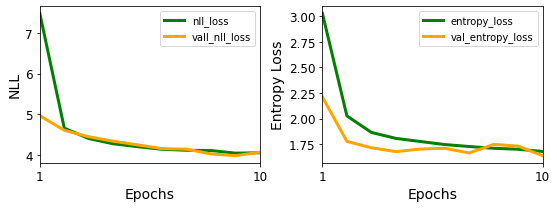

Saved scrambler model at saved_models/mer8motif_model_cnn_inclusion_scrambler_bits_0125_epochs_10.h5 


In [126]:
cnn_scr, cnn_scr_train_hist = train_scrambler_on_model(new_jtest_reload)
model_name = 'mer8motif_model_cnn_inclusion_scrambler_bits_0125_epochs_10'
save_scrambler(cnn_scr, cnn_scr_train_hist, model_name)

13088/13088 [==============================] - 23s 2ms/step
Test sequence 4:
 - Prediction (original) = 18.8
 - Predictions (scrambled) = [15.6, 15.8, 19.4, 15.6, 15.0, 18.0, 16.1, 15.7, 16.2, 15.6, 16.1, 21.7, 17.3, 18.3, 15.9, 17.6, 16.9, 15.9, 11.4, 15.3, 15.0, 14.8, 15.6, 15.8, 14.9, 18.6, 17.0, 15.2, 17.3, 15.5, 16.2, 16.8]


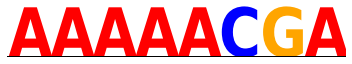

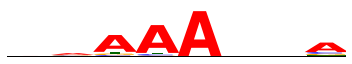

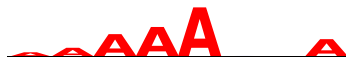

Test sequence 133:
 - Prediction (original) = 8.12
 - Predictions (scrambled) = [4.58, 4.38, 5.29, 5.52, 4.41, 4.58, 4.69, 4.55, 5.64, 4.92, 6.14, 5.33, 6.38, 4.9, 5.29, 6.21, 5.18, 5.02, 5.0, 4.61, 4.96, 5.61, 5.17, 4.28, 4.55, 4.39, 5.08, 5.39, 4.95, 6.66, 4.91, 4.73]


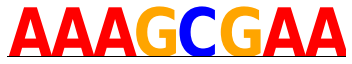

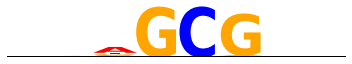

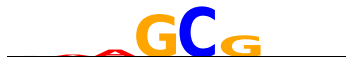

Test sequence 97:
 - Prediction (original) = 27.0
 - Predictions (scrambled) = [26.0, 23.6, 25.8, 24.9, 24.2, 24.8, 25.0, 23.9, 24.2, 22.4, 24.9, 23.9, 24.9, 20.9, 23.8, 25.8, 23.7, 26.6, 23.5, 23.7, 23.3, 26.1, 24.4, 24.6, 24.7, 25.4, 23.2, 23.8, 24.4, 27.2, 24.1, 24.8]


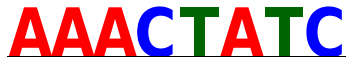

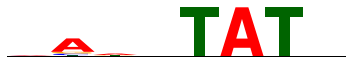

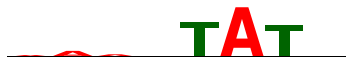

Test sequence 99:
 - Prediction (original) = 18.1
 - Predictions (scrambled) = [17.1, 17.3, 15.9, 16.3, 16.2, 16.6, 16.8, 18.6, 17.4, 16.1, 17.3, 16.8, 18.3, 17.5, 17.8, 19.1, 17.8, 16.2, 25.3, 18.9, 17.0, 17.0, 17.4, 17.2, 16.7, 17.4, 16.5, 16.0, 17.4, 15.8, 17.7, 17.0]


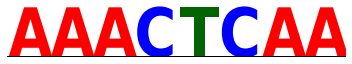

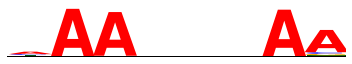

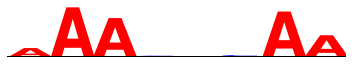

Test sequence 13074:
 - Prediction (original) = 23.6
 - Predictions (scrambled) = [22.5, 22.9, 23.8, 23.7, 23.5, 25.9, 23.0, 20.2, 23.5, 23.8, 25.2, 25.2, 25.2, 23.2, 22.3, 22.6, 22.9, 23.5, 26.4, 23.9, 25.1, 23.3, 22.7, 24.3, 23.6, 23.8, 25.0, 22.8, 19.2, 19.0, 25.3, 24.4]


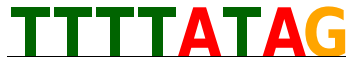

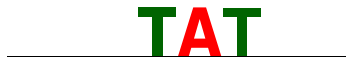

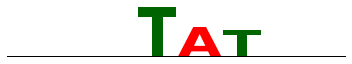

Test sequence 13075:
 - Prediction (original) = 14.0
 - Predictions (scrambled) = [16.9, 13.8, 10.6, 19.2, 15.6, 13.9, 13.6, 13.0, 15.0, 14.6, 16.8, 15.4, 17.6, 14.5, 14.5, 13.4, 14.4, 6.68, 15.8, 14.4, 13.4, 15.4, 14.7, 14.9, 14.8, 13.9, 13.5, 14.0, 15.5, 14.6, 14.9, 14.2]


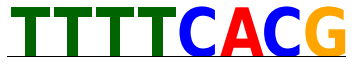

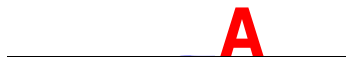

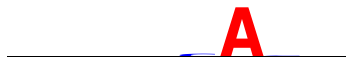

Test sequence 578:
 - Prediction (original) = 25.1
 - Predictions (scrambled) = [22.2, 22.4, 22.7, 24.6, 24.6, 24.7, 24.3, 23.9, 24.4, 22.9, 25.0, 22.7, 23.7, 22.4, 25.3, 27.5, 24.5, 23.7, 22.6, 22.8, 23.0, 23.2, 23.5, 23.6, 23.2, 24.0, 23.7, 27.2, 24.2, 24.1, 25.3, 23.2]


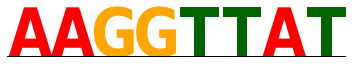

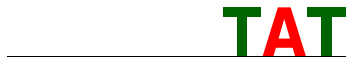

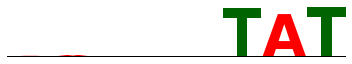

Test sequence 579:
 - Prediction (original) = 14.7
 - Predictions (scrambled) = [11.6, 14.0, 14.3, 12.9, 18.0, 16.0, 16.6, 14.1, 15.3, 15.5, 12.2, 7.76, 15.5, 15.2, 15.1, 16.6, 14.9, 14.5, 16.2, 13.9, 10.7, 16.0, 21.5, 15.1, 16.2, 14.4, 14.7, 22.8, 14.0, 24.5, 15.5, 14.4]


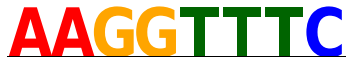

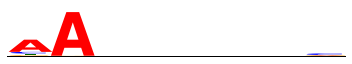

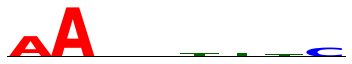

Test sequence 438:
 - Prediction (original) = 6.99
 - Predictions (scrambled) = [4.47, 5.44, 5.51, 5.59, 8.64, 5.74, 7.82, 5.09, 4.49, 5.03, 5.82, 5.24, 4.58, 5.58, 4.2, 5.37, 5.01, 8.69, 4.26, 4.12, 5.02, 4.87, 4.53, 6.14, 4.75, 4.26, 6.71, 5.65, 5.14, 5.05, 5.21, 5.69]


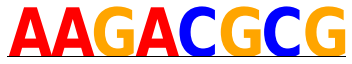

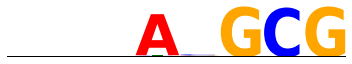

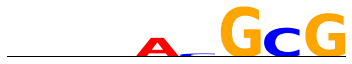

Test sequence 439:
 - Prediction (original) = 17.0
 - Predictions (scrambled) = [19.4, 16.0, 15.4, 14.5, 15.1, 14.0, 15.9, 16.8, 15.6, 16.7, 15.2, 16.0, 15.5, 15.7, 17.1, 14.2, 15.4, 16.4, 14.7, 15.6, 17.1, 13.8, 15.9, 14.2, 14.7, 13.8, 14.8, 15.5, 17.6, 16.3, 16.2, 14.2]


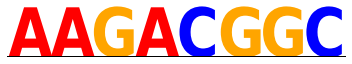

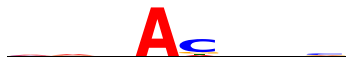

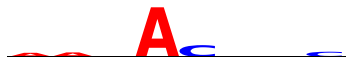

In [140]:
viz_scrambler_results(new_jtest_reload, cnn_scr)

In [131]:
x_test[4:5, ...][0].shape

(1, 8, 4)

In [134]:
[x_test[4:5, ...]]

[array([[[[1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [1., 0., 0., 0.]]]])]

In [139]:
def viz_scrambler_results(model, scrambler, verbose=False):
    #Interpret the test set using the trained scrambler
    pwm_test, sample_test, importance_scores_test = scrambler.interpret(x_test)
    
    if verbose:
        print("x_test:",x_test.shape)
        print("pwm_test:",pwm_test.shape)
        print("sample_test:",sample_test.shape)
        print("importance_scores_test:",importance_scores_test.shape)
        
    
    #Visualize a few reconstructed sequence patterns
    plot_examples = np.arange(5).tolist()
    save_examples = []

    importance_scores_test *= sequence_mask[None, None, :, None]

    for test_ix in ixs :
        #seq = x_test2[test_ix:test_ix+1, ...].flatten().reshape(1,-1)
        
        #seq = x_test[test_ix:test_ix+1, ...][0]#.reshape(1,-1)
        seq = x_test[test_ix:test_ix+1, ...]
        
        print("Test sequence " + str(test_ix) + ":")

        #sample_seqs = sample_test[test_ix, ...]
        #x=           [sample_test[test_ix, ...]], batch_size=32)
        
        # reshape
        #sample_seqs = np.array([x.flatten().reshape(1,-1) for x in sample_seqs])

    #     y_test_hat_ref = k_reload.predict(x=[seq], batch_size=1)[0, 0]
    #     y_test_hat = k_reload.predict(x=[sample_seqs], batch_size=32)[:32, 0].tolist()
        y_test_hat_ref = model.predict(x=[seq])[0, 0]
        
        #y_test_hat = [model.predict(x=[ss])[0, 0] for ss in sample_seqs]
        y_test_hat = model.predict(x=[sample_test[test_ix, ...]], batch_size=32)[:32, 0].tolist()
        
        print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
        print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))

        save_figs = False
        if save_examples is not None and test_ix in save_examples :
            save_figs = True

        # Original seq
        plot_dna_logo(x_test[test_ix, 0, :, :], 
                      sequence_template=sequence_template, 
                      figsize=(5, 1), 
                      plot_start=0, plot_end=SEQ_LEN, 
                      plot_sequence_template=True, 
                      save_figs=save_figs, 
                      fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence"
        )
        # PWM
        plot_dna_logo(pwm_test[test_ix, 0, :, :], 
                      sequence_template=sequence_template, 
                      figsize=(5, 1), 
                      plot_start=0, plot_end=SEQ_LEN, 
                      plot_sequence_template=True, 
                      save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm"
        )
        # importance scores
        plot_dna_importance_scores(importance_scores_test[test_ix, 0, :, :].T,
                                   encoder.decode(x_test[test_ix, 0, :, :]), 
                                   figsize=(5, 1), 
                                   score_clip=None, 
                                   sequence_template=sequence_template, 
                                   plot_start=0, plot_end=SEQ_LEN, 
                                   save_figs=save_figs, 
                                   fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores"
        )
  